In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
wdir = Path('/cellar/users/dlaub/projects/log_euclidean_signature/dsc291-final-project')

import sys
sys.path.insert(0, str(wdir))

In [3]:
from les.les import les_desc_comp, les_dist_comp
import bento
import seaborn as sns
import numpy as np
from tqdm import tqdm
import leidenalg as lei
from scipy.spatial.distance import cdist
import igraph as ig
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import polars as pl
from matplotlib.colors import to_hex
import geopandas as gpd
import matplotlib.pyplot as plt
import scipy.stats as st

In [4]:
a1 = bento.io.read_h5ad(wdir/'data'/'A1-lp.h5ad')
d1 = bento.io.read_h5ad(wdir/'data'/'D1-lp.h5ad')
bento.tl.flow(a1, mode="point", radius=20, normalization="log", reduce=True)
bento.tl.flow(d1, mode="point", radius=20, normalization="log", reduce=True)

  0%|          | 0/1487 [00:00<?, ?it/s]

Normalizing embedding...
Reducing dimensionality...
Done.
AnnData object modified:
    uns:
        + flow_pca, flow, flow_genes


In [5]:
adata.uns['points'].reset_index(drop=True, inplace=True)

In [6]:
min_pts = 92
gt_92_pts = adata.uns['points'].groupby('cell').transform('count')['x'] >= min_pts
points = adata.uns['points'][gt_92_pts].reset_index(drop=True)
points['gene'] = points['gene'].cat.remove_unused_categories()
points['cell'] = points['cell'].cat.remove_unused_categories()
points['nucleus'] = points['nucleus'].cat.remove_unused_categories()
flow = adata.uns['flow'][gt_92_pts]
obs = adata.obs[adata.obs.index.isin(points['cell'].unique())]

In [7]:
adata2 = adata[adata.obs.index.isin(points['cell'].unique())]

In [7]:
ss = StandardScaler()
ss_flow = ss.fit_transform(flow.todense())

### LES on RNAflow

1. Get RNAflow (represent each point as gene counts of neighbors) $\to$ (c p g)
    - Can be grouped by cell and/or gene
2. For each cell, compute the LE descriptor (log eigenvalues) $\to$ (c p)
3. Cluster the cells using their LE descriptors (from cell-pairwise LES). (c c) $\to$ (c) clusters

This doesn't recover anything resembling cell types. Why?

- Needed to standardize the counts? Doesn't seem to make much of a difference.
- Because distances destroy gene-level information i.e. $d([1, 0], [0, 0]) = d([0, 1], [0, 0])$ but different genes are driving the difference. Gene-level information identifies cell type.

In [10]:
# takes ~2 minutes with sparse matrices (non-standardized)
# takes ~3.5 minutes with dense matrices (standardized)
# les_desc = []
# for cell_id, g in tqdm(points.groupby('cell')):
#     les_desc.append(les_desc_comp(flow[g.index].toarray(), nev=min_pts))
# flow_les = np.stack(les_desc, axis=0)
# np.save(wdir/'data'/'flow_les_desc.npy', flow_les)
flow_les = np.load(wdir/'data'/'flow_les_desc.npy')

In [11]:
adata2.obsm['X_flow_les'] = flow_les

In [12]:
adata2.obs['les_0'] = flow_les[:, 0]
adata2.obs['les_1'] = flow_les[:, 1]
adata2.obs['les_2'] = flow_les[:, 2]

In [13]:
flow_les_0_1 = ((flow_les - flow_les.min(0))/(flow_les.max(0) - flow_les.min(0)))
flow_les_hex = np.array([to_hex(v) for v in flow_les_0_1[:, :3]])
adata2.obs['les_012_hex'] = flow_les_hex

In [125]:
st.pearsonr(adata2.obs['total_counts'], adata2.obs['les_0'])

PearsonRResult(statistic=0.42984747962667635, pvalue=3.198771353688953e-51)

In [15]:
st.pearsonr(adata2.obs['cell_density'], adata2.obs['les_0'])

PearsonRResult(statistic=0.25577377792480704, pvalue=4.549919211470285e-18)

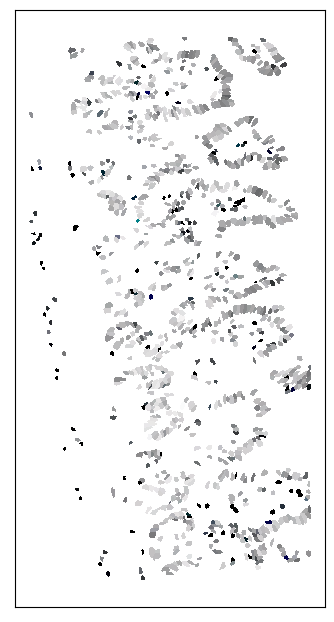

In [119]:
fig, ax = plt.subplots(figsize=(4, 10))
gpd.GeoDataFrame(adata2.obs, geometry='cell_shape').plot(color=flow_les_hex, ax=ax)
ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

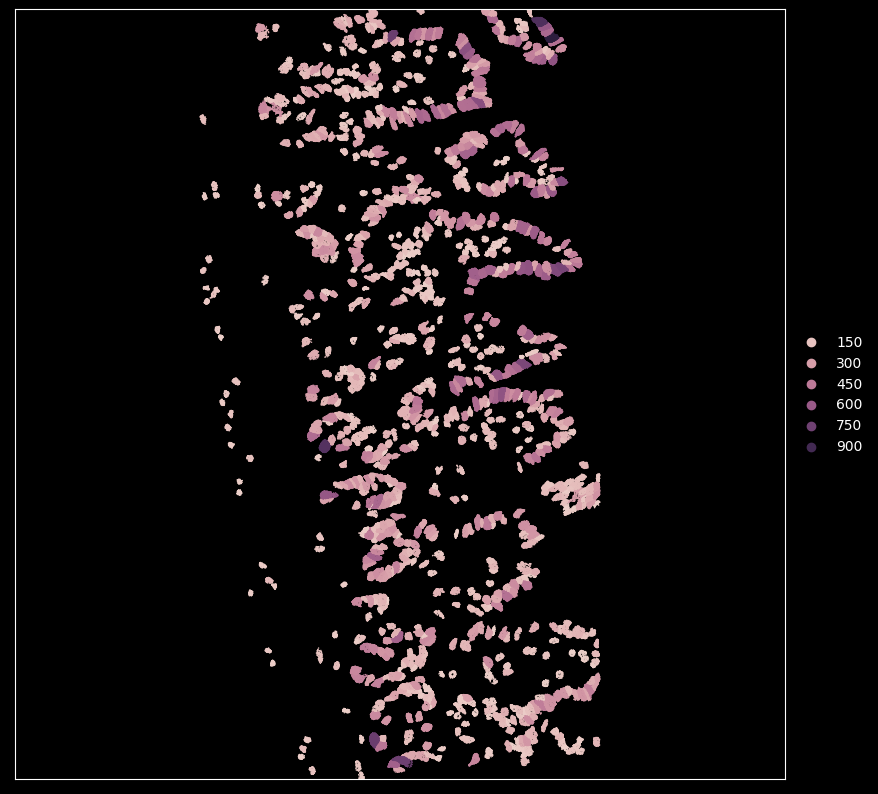

In [126]:
bento.pl.plot(adata2, kind='scatter', hue='total_counts', height=10, shape_names=[])

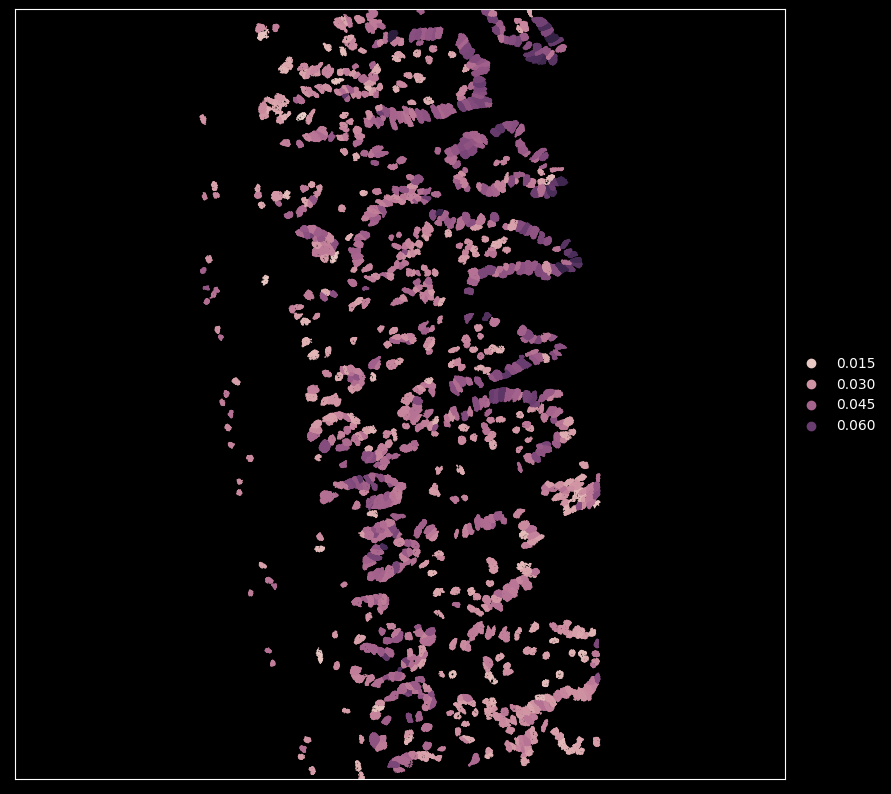

In [14]:
bento.pl.plot(adata2, kind='scatter', hue='cell_density', height=10, shape_names=[])

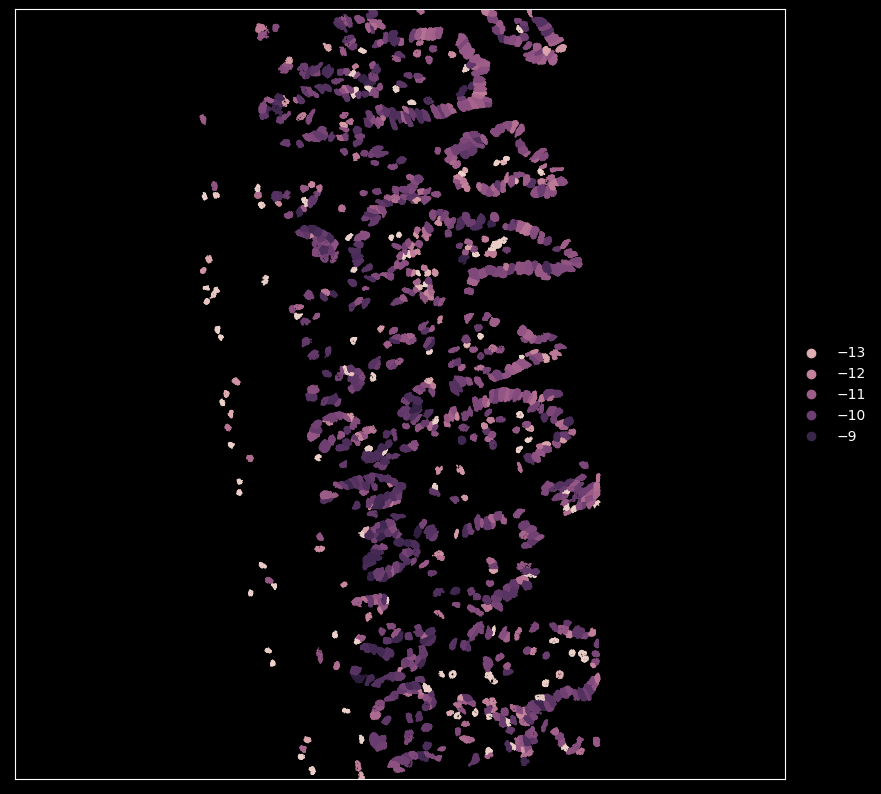

In [85]:
bento.pl.plot(adata2, kind='scatter', hue='les_0', height=10, shape_names=[])

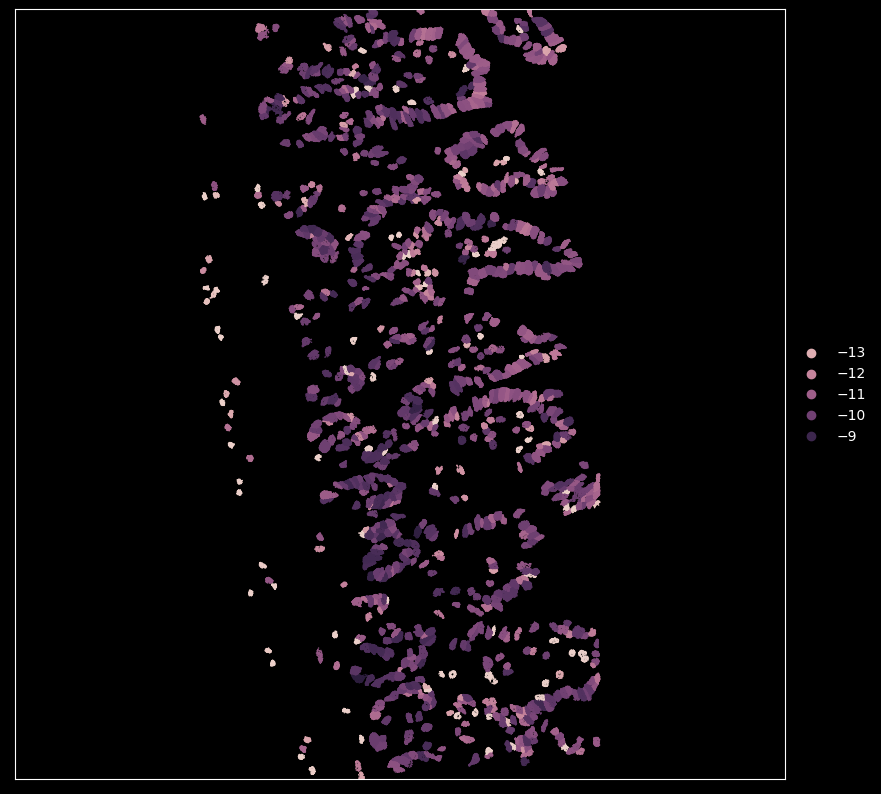

In [87]:
bento.pl.plot(adata2, kind='scatter', hue='les_1', height=10, shape_names=[])

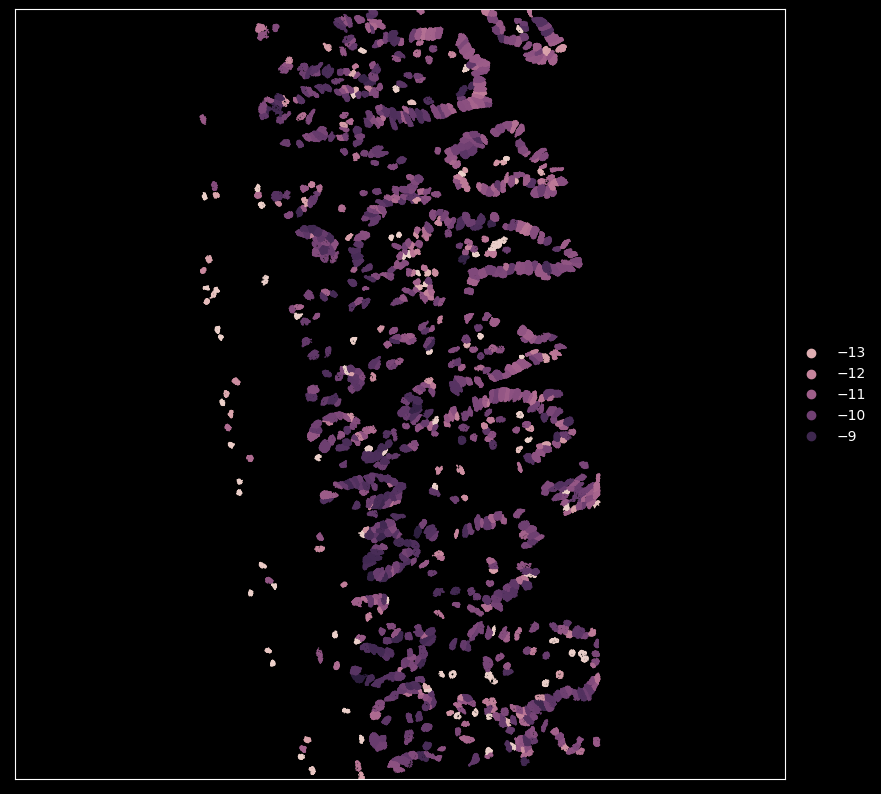

In [88]:
bento.pl.plot(adata2, kind='scatter', hue='les_2', height=10, shape_names=[])

In [10]:
pdists = cdist(flow_les, flow_les)

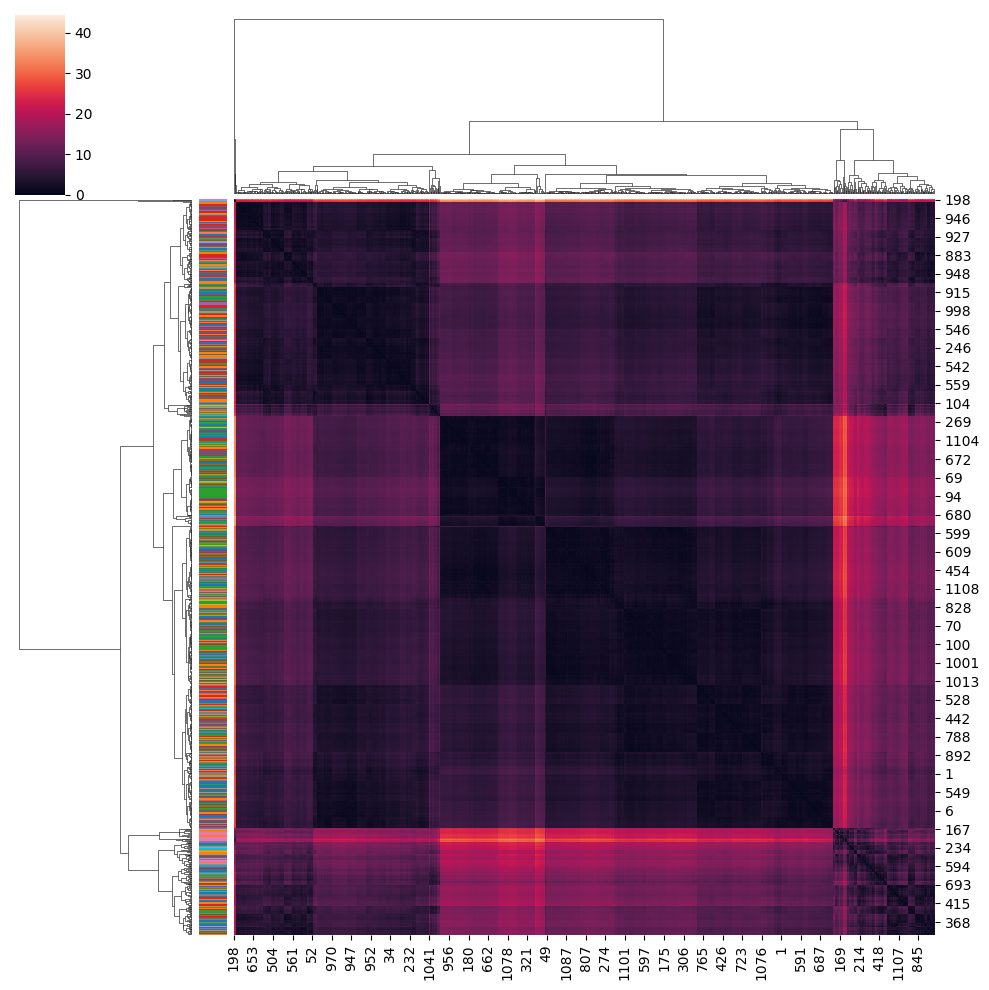

In [14]:
row_colors = obs['leiden'].astype(str).map(dict(zip(obs['leiden'].unique(), sns.color_palette('tab10', obs['leiden'].nunique()))))
sns.clustermap(pdists, row_colors=row_colors.to_numpy())

In [62]:
clusters = lei.find_partition(
    ig.Graph.Weighted_Adjacency(pdists, mode='undirected'),
    lei.ModularityVertexPartition,
    # resolution_parameter=1.0009000900089998,
    n_iterations=5
)
clusters = np.array(clusters.membership)
len(np.unique(clusters))

1

In [18]:
cmap = dict(zip(np.unique(clusters), sns.color_palette('tab10', len(np.unique(clusters)))))

In [24]:
sorter = np.argsort(obs['leiden'])

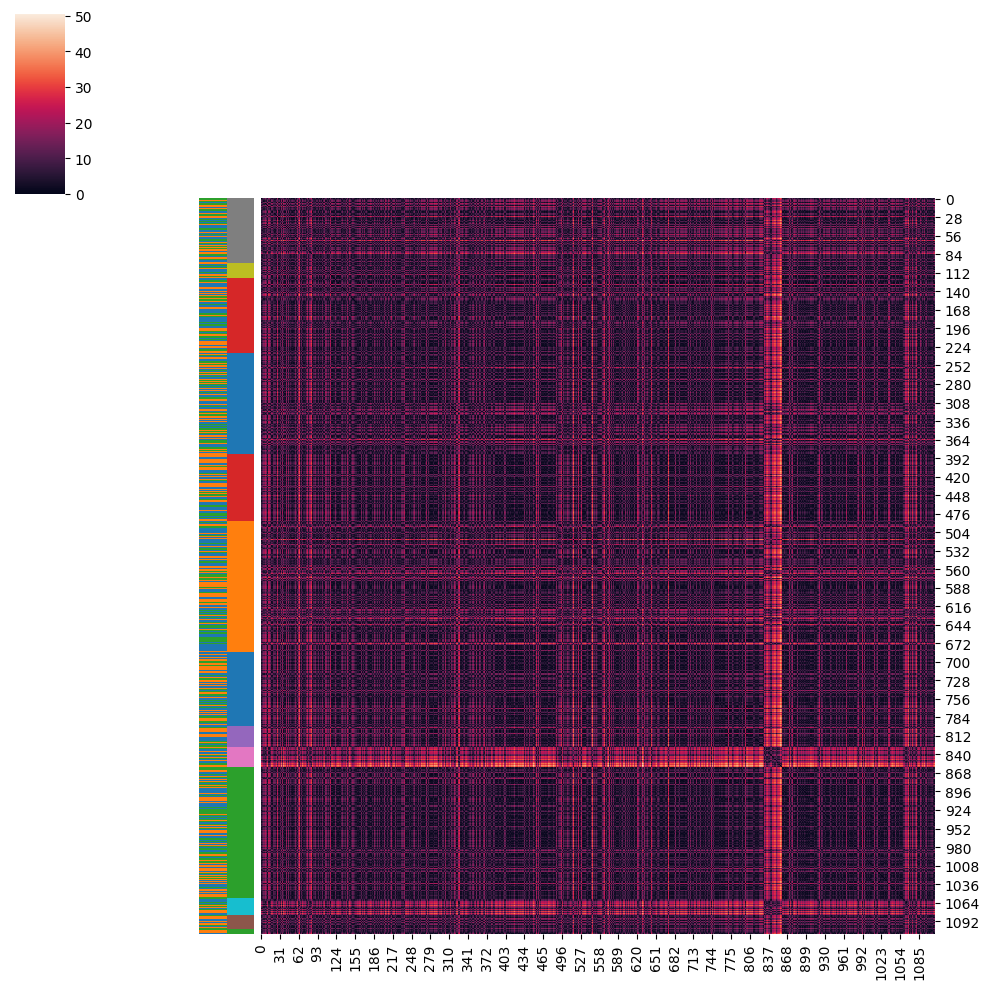

In [26]:
sns.clustermap(pdists[sorter][:, sorter], row_colors=[[cmap[c] for c in clusters[sorter]], row_colors.to_numpy()[sorter]], row_cluster=False, col_cluster=False)

### LES on each gene separately

1. For each gene and cell (g c), get LE descriptor using (x y) coordinates. (g c p d) $\to$ (g c p)
    - where p = points, d = dimensionality (2, for x & y)
2. For each gene, compute the LE distance between all cells. $\to$ (g c c)
    - **This fails because some genes are simply not expressed in all cells.**
3. Compute multiplex Leiden clusters, letting each gene represent a different edge type. $\to$ (c)

In [16]:
pl_points = pl.from_pandas(points)

In [17]:
def les_desc_wrapper(g: pl.DataFrame):
    desc = les_desc_comp(g[['x', 'y']].to_numpy())
    df = pl.DataFrame(desc.reshape(1, -1))
    df = df.select([
        pl.lit(g[0, 'gene']).alias('gene'),
        pl.lit(g[0, 'cell']).alias('cell'),
        pl.concat_list(pl.all()).alias('les_desc')
    ])
    return df

gene_cell_desc = (
    pl_points
    .filter(pl.count('x').over(['cell', 'gene']) > 10)
    .groupby(['cell', 'gene'])
    .apply(les_desc_wrapper)
)

In [26]:
gene_cell_desc = gene_cell_desc.select(['gene', 'cell']).with_row_count().join(
    gene_cell_desc['les_desc']
    .arr.slice(0, 11)
    .arr.to_struct(name_generator=lambda idx: f'eigval_{idx}')
    .struct.to_frame()
    .with_row_count(),
    on='row_nr'
).drop('row_nr')

In [27]:
gene_cell_desc.head()

gene,cell,eigval_0,eigval_1,eigval_2,eigval_3,eigval_4,eigval_5,eigval_6,eigval_7,eigval_8,eigval_9,eigval_10
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Sdc1""","""4686""",-11.413261,-10.306962,-7.469826,-6.710882,-6.257699,-4.854189,-4.262514,-2.927255,-2.467826,-1.773935,-0.565258
"""Cps1""","""4971""",-13.668707,-12.600379,-11.648892,-10.231966,-8.430924,-8.068248,-6.684243,-5.592698,-5.490524,-3.956146,-3.055056
"""Maoa""","""3537""",-13.81118,-13.631831,-12.716475,-12.481745,-11.666666,-10.462513,-9.361091,-8.317582,-7.377649,-6.947443,-6.162575
"""Maoa""","""3653""",-8.421552,-7.805028,-6.265467,-5.325471,-4.487955,-3.430089,-3.328642,-2.037422,-1.087786,-0.809638,1.0000e-6
"""Neat1""","""886""",-13.815511,-13.815511,-13.815511,-13.815511,-13.81551,-13.81551,-13.81551,-13.815509,-13.815507,-13.815494,-13.815492


In [28]:
desc = gene_cell_desc.select(pl.exclude(['gene', 'cell'])).to_numpy()
test = cdist(desc, desc)

In [31]:
gene_cell = gene_cell_desc.select(['gene', 'cell']).to_numpy()

In [40]:
gene_cell_desc['gene'].value_counts()

gene,counts
str,u32
"""Cps1""",321
"""Lrmp""",8
"""Net1""",73
"""Clca3b""",371
"""Slc12a2""",98
"""Sox10""",1
"""Kit""",41
"""Neat1""",861
"""Klk1""",56


In [36]:
test[np.ix_(gene_cell[:, 0] == gene_cell[0, 0], gene_cell[:, 0] == gene_cell[0, 0])]

array([[ 0.        ,  9.04212427, 11.01486634, ...,  4.52095079,
        29.76145623, 16.1166978 ],
       [ 9.04212427,  0.        ,  3.30429545, ...,  5.42885849,
        21.65944793,  7.86428286],
       [11.01486634,  3.30429545,  0.        , ...,  7.12629462,
        20.26633796,  6.11596609],
       ...,
       [ 4.52095079,  5.42885849,  7.12629462, ...,  0.        ,
        26.62291794, 12.58148082],
       [29.76145623, 21.65944793, 20.26633796, ..., 26.62291794,
         0.        , 14.4937832 ],
       [16.1166978 ,  7.86428286,  6.11596609, ..., 12.58148082,
        14.4937832 ,  0.        ]])